In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Preparation

In [2]:
df = pd.read_csv("/notebooks/Text-Multiclass-Classification/data_input/770 Whole Thread LabelledU.csv", index_col=0)
df = df[['clean_text', 'Dominant Label']]
df.head()

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,VLE and Module
1,compromise manatee might send add...,Unclassifiable
2,reassign setup rove mikes room lib opsbusadm...,Hardware and Room
3,conference facilities room next wednesday b...,Hardware and Room
4,room seem lack function mfd room scan usb ...,Hardware and Room


### Remove row labeled : ['unclassifiable', 'None', and 'Network and database']

In [3]:
df["Dominant Label"].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Unclassifiable           30
Network and Database     25
None                      2
Name: Dominant Label, dtype: int64

In [4]:
unclassifiable_mask = (df['Dominant Label'] != 'Unclassifiable')
none_mask = (df['Dominant Label'] != 'None')
network_database_mask = (df['Dominant Label'] != 'Network and Database')

In [5]:
df = df[unclassifiable_mask & none_mask & network_database_mask]
df['Dominant Label'].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Name: Dominant Label, dtype: int64

In [6]:
label = df['Dominant Label'].unique()

In [7]:
# Encode the Dominant Label to integer value

df['Dominant Label'] = df['Dominant Label'].map({'VLE and Module' : 0,
                                                 'Hardware and Room' : 1,
                                                 'Mail' : 2,
                                                 'Software and Access' : 3,
                                                 'Account and Password' : 4 })                                         

# it's oke if we got Warning after running this code

### Handle Missing and Duplicate data

In [8]:
# Detect missing values
# isna() will check column if there is Nan, null, or na data it will return True  if not then False
# Since True = 1 and False = 0. when we sum together each True and False then we will know how many missing values is
df.isna().sum()

clean_text        0
Dominant Label    0
dtype: int64

In [9]:
True + True + True

3

In [10]:
# Detect Duplicate data

df[df.duplicated(keep = False)]

# df.duplicated when we set keep = False : Mark all duplicates as True.

,clean_text,Dominant Label
Count,,
91,add mail address brl mail list colleague add...,2
95,add mail address brl mail list colleague add...,2
102,add mail address brl mail list colleague add...,2


In [11]:
# Remove the duplicates data
df = df.drop_duplicates()

In [12]:
df

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,0
2,reassign setup rove mikes room lib opsbusadm...,1
3,conference facilities room next wednesday b...,1
4,room seem lack function mfd room scan usb ...,1
5,phone frustrate polycom phone sign skype wont...,1
...,...,...
764,authenticator failure sign anything microso...,2
765,password password way reset apparently reg...,1
766,phone line student support line support phon...,3


In [13]:
X, y = df['clean_text'], df['Dominant Label']

### Train Test Split



In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing Data

NLTK vs Tensorflow

NLTK : usually we need to below step :<br>
    1. Case Folding <br>
    2. Tokenization <br>
    3. Stop words removal <br>
    4. Digit Removal <br>
    5. Punctuation Removal <br>
    6. Non ASCII-Removal 
    
when we come to Tensorflow, we just need to do :<br>
    1. Tokenization <br>
    2. stop words removal (optional)<br>
because Tokenization will include to handle the Case Folding, Digit Removal, Punctuation and Non ASCII

In [15]:
# Vocabulary size of the tokenizer
vocab_size = 150

# Maximum length of the padded sequences
max_length = 8

# Output dimensions of the Embedding layer
embedding_dim = 8

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

## Modeling

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 8)              1200      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                216       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________


In [17]:
len(y_train)

532

In [18]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
num_epochs = 100

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/100
17/17 [==============================] - 0s 11ms/step - loss: 0.5304 - accuracy: 0.8064 - val_loss: 1.9617 - val_accuracy: 0.4494
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5310 - accuracy: 0.8083 - val_loss: 1.9746 - val_accuracy: 0.4551
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5297 - accuracy: 0.8045 - val_loss: 1.9803 - val_accuracy: 0.4494
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 0.5276 - accuracy: 0.8064 - val_loss: 1.9860 - val_accuracy: 0.4607
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5266 - accuracy: 0.8045 - val_loss: 1.9961 - val_accuracy: 0.4551
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5256 - accuracy: 0.8083 - val_loss: 2.0021 - val_accuracy: 0.4551
Epoch 7/100
17/17 [==============================] - 0s 8ms/step - loss: 0.5248 - accuracy: 0.8083 - val_loss: 2.0115 - val_accuracy: 0.4551
Epoch 8/100


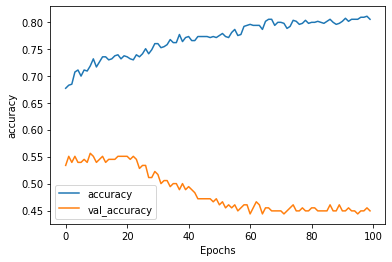

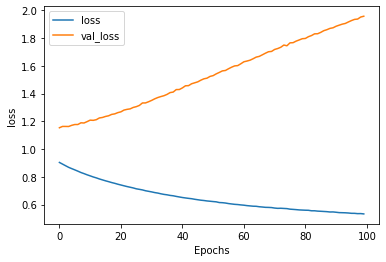

In [21]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")